In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
from numpy.random import default_rng, SeedSequence
import multiprocessing
import concurrent.futures

### Questions

If we can keep track of edges hit, what does the sequence look like? x

Are there protected zones? x

Amoung the first n bounces, what proportion of the hits are on a particular edge for a random trajectory? x

How does this depend on the side length of the polygon?

What about trajectories that visit only 2 of the edges?

In [2]:
rng = default_rng()

In [3]:
error = 1e-10 #because machine error is *really* important when working with linalg

In [4]:
def normalize(v):
    l = np.linalg.norm(v)
    if l < error:
        print("Something has gone terribly wrong with "+str(v))
        return v
    return v/l#np.multiply(1/l,v)

In [5]:
def ngon(n):
    theta = 2*np.pi/n
    angles = np.array([x*theta for x in range(n)])
    p0s = np.vstack((np.cos(angles),np.sin(angles))).T
    p1s = np.array(list(map(lambda i: p0s[(i+1)%n],range(n))))
    return np.array(list(zip(p0s,p1s)))

In [6]:
def line_hit(x,v,p0,p1,verbose=False):
    dp = p0-p1#np.subtract(p0,p1)
    a = np.vstack((v,dp)).T
    b = p0-x#np.subtract(p0,x)
    t = np.linalg.solve(a,b)
    nx = x+t[0]*v #np.add(x,np.multiply(t[1],v))
    p = p0-t[1]*dp#np.add(p0,np.multiply(t[0],dp))
    if t[1] < 1 and t[1] > 0 and t[0] > 0 and np.linalg.norm(p-nx) < error:
        n = np.array([-dp[1],dp[0]])
        dot = -np.dot(n,p)
        if dot != 0:
            n = dot*n#np.multiply(dot,n) # make sure the norm is pointed the right way
        if verbose:
            print("intersect "+str(t))
            print("prenorm "+str(n))
            print("dot "+str(dot))
            print("normal "+str(n))
        return True, (p,n,(x,v,t[0]))
    else:
        return False, ()

In [7]:
def polygon_hit(ps):
    def hit(x,v):
        hits = map(lambda p: line_hit(x,v,*p[1])+(p[0],),enumerate(ps))
        crossings = list(map(lambda x: (x[1],x[2]), filter(lambda x: x[0], hits)))
        cross = sorted(crossings,key=lambda x: x[0][2][2])[0]
        p = cross[0][0]
        n = cross[0][1]
        s = cross[1]
        return p, n, s
    return hit

In [8]:
def circle_hit(x,v):
    b = np.dot(v,x)
    c = np.linalg.norm(x)**2 -1
    x2 = np.linalg.norm(x)**2
    ts = -b+np.array([1,-1])*np.sqrt(b**2 - c)
    t = ts.min()
    p = x+t*v
    n = -p
    return p, n, np.arctan2(x[1],x[0])

normal vector to curve is just 2nd derivative

In [9]:
def bounce(v,n):
    n = normalize(n)
    return v-2*np.dot(n,v)*n#np.subtract(v,np.multiply(2*np.dot(n,v),n))

In [10]:
def randx(rad):
    r = rng.random()*rad
    theta = 2*np.pi*rng.random()
    x = np.multiply(r,np.array([np.cos(theta),np.sin(theta)]))
    return x
def randv():
    vtheta = 2*np.pi*rng.random()
    v = np.array([np.cos(vtheta),np.sin(vtheta)])
    return v

In [11]:
def sim(hitFunc,x,v,depth):
    lines = [(x,v,-1)]
    for _ in range(depth):
        x, n, s = hitFunc(x,v)
        v = bounce(v,n)
        x = x+error*v#np.add(x,np.multiply(1e-12,v))
        lines = lines + [(x,v,s)]
    return lines

In [12]:
def side_chance(sim_result):
    s = np.array(list(map(lambda x: x[2],sim_result[1:])))
    uniques = np.unique(s)
    counts = np.array(list(map(lambda u: sum(1 for side in s if side == u),uniques)))
    counts = normalize(counts)
    return uniques,counts

In [13]:
sides = 4
bounces = 10000
ng = ngon(sides)
nghit = polygon_hit(ng)

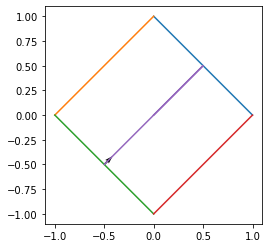

In [14]:
ls = sim(nghit,np.array([0,0]),np.array([1,1]),bounces)
plt.plot(*ng.T)
xs = list(map(lambda x: x[0][0], ls))
ys = list(map(lambda x: x[0][1], ls))
plt.plot(xs,ys)
x,v,_ = ls[-1]
plt.quiver(*x,*v)
ax = plt.gca()
ax.set_aspect(1)
plt.show()

<BarContainer object of 2 artists>

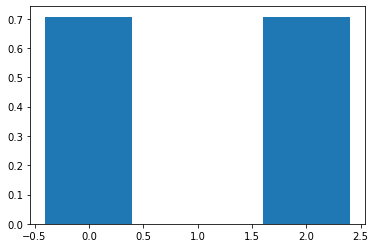

In [15]:
ss = list(map(lambda x: x[2],ls[1:]))
#print(ss)
#ax = plt.gca()
#ax.hist(ss,bins=2*sides)
us,cs = side_chance(ls)
plt.bar(us,cs)

(array([-0.5      ,  0.8660254]), array([-1.00000000e+00,  2.58951638e-10]), 3.1415926534174843)


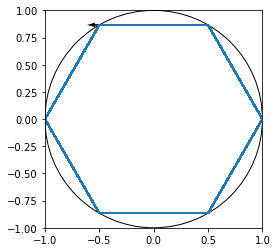

In [16]:
theta = np.pi/3
ls = sim(circle_hit,np.array([1,0]),np.array([np.cos(theta),np.sin(theta)]),bounces)
xs = list(map(lambda x: x[0][0], ls))
ys = list(map(lambda x: x[0][1], ls))
#print(xs)
plt.plot(xs,ys)
print(ls[-1])
x,v,_ = ls[-1]
plt.quiver(*x,*v)
draw_circle = plt.Circle((0, 0), 1,fill=False)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.gcf().gca().add_artist(draw_circle)
plt.gca().set_aspect(1)
plt.show()

<BarContainer object of 10000 artists>

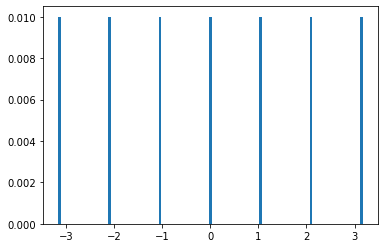

In [17]:
ss = list(map(lambda x: x[2],ls[1:]))
#print(ss)
#ax = plt.gca()
#ax.hist(ss,bins=bounces)
us,cs = side_chance(ls)
plt.bar(us,cs,width=0.05)

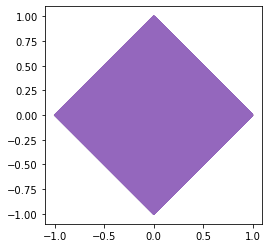

In [18]:
ls = sim(nghit,randx(np.cos(np.pi/sides)),randv(),bounces)
plt.plot(*ng.T)
xs = list(map(lambda x: x[0][0], ls))
ys = list(map(lambda x: x[0][1], ls))
plt.plot(xs,ys)
x,v,_ = ls[-1]
plt.quiver(*x,*v)
ax = plt.gca()
ax.set_aspect(1)
plt.show()

<BarContainer object of 4 artists>

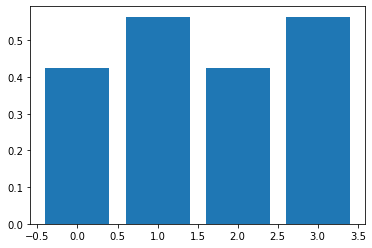

In [19]:
ss = list(map(lambda x: x[2],ls[1:]))
#print(ss)
#ax = plt.gca()
#ax.hist(ss,bins=2*sides)
us,cs = side_chance(ls)
plt.bar(us,cs)

(array([-0.63997536,  0.76839543]), array([-0.88696962,  0.46182777]), -1.6688808238909099)


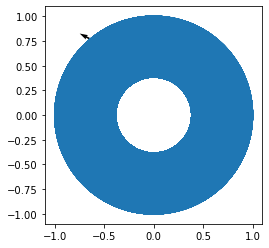

In [20]:
ls = sim(circle_hit,randx(0.9),randv(),bounces)
xs = list(map(lambda x: x[0][0], ls))
ys = list(map(lambda x: x[0][1], ls))
plt.plot(xs,ys)
print(ls[-1])
x,v,_ = ls[-1]
plt.quiver(*x,*v)
draw_circle = plt.Circle((0, 0), 1,fill=False)
plt.gcf().gca().add_artist(draw_circle)
plt.gca().set_aspect(1)
plt.show()

<BarContainer object of 10000 artists>

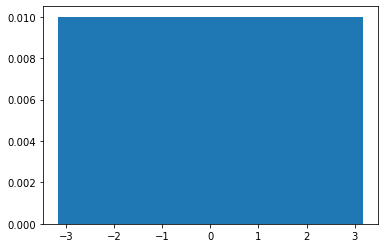

In [21]:
ss = list(map(lambda x: x[2],ls[1:]))
#print(ss)
#ax = plt.gca()
#ax.hist(ss,bins=bounces)
us,cs = side_chance(ls)
plt.bar(us,cs,width=0.05)